# Imports

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os

import string 

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from sklearn.svm import LinearSVC

import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from joblib import dump
from skimage.color import rgb2lab
from IPython.display import display
import cv2
from skimage.feature import local_binary_pattern

# Exploration

## Raw data import 

In [2]:
X = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")
y = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")
y_umbr = np.load("../raw_data/tmp_data/y_train_umbr.npy", encoding='bytes', allow_pickle=True)

In [3]:
X

,Image_name,Title
Id,,
0,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear
1,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz..."
2,1446276082.jpg,Energy Security (SAGE Library of International...
3,1491522666.jpg,An Amish Gathering: Life in Lancaster County
4,0970096410.jpg,City of Rocks Idaho: A Climber's Guide (Region...
...,...,...
51295,0399176055.jpg,Extreme Prey
51296,0719816629.jpg,The Crime Writer's Guide to Police Practice an...
51297,0385353596.jpg,The Jezebel Remedy: A novel


In [4]:
y_umbr_df = pd.DataFrame(y_umbr)
y_umbr_df = y_umbr_df.rename(columns={
    y_umbr_df.columns[0]: 'Genre_id',
    y_umbr_df.columns[1]: 'Genre_name',
    y_umbr_df.columns[2]: 'Genre_umbr_name',
    y_umbr_df.columns[3]: 'Genre_umbr_id'
})

#y_umbr = y_umbr.rename_axis('Genre_id')
y_umbr_df

,Genre_id,Genre_name,Genre_umbr_name,Genre_umbr_id,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
51295,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51297,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51298,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
genre_dict = y_umbr_df.set_index('Genre_umbr_id')['Genre_umbr_name'].to_dict()
genre_dict

{0.0: 0.0, 1.0: 0.0}

## Preliminary Data Preprocessing

### Images

In [13]:
array_test = np.array([])

for image_name in X['Image_name'][:5]:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    image_array = np.array(image)

    flattened_pixels = image_array.reshape(-1, 3)
    average_color = np.mean(flattened_pixels, axis=0)
    unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
    most_frequent_index = np.argmax(counts)
    most_frequent_color = unique[most_frequent_index]
    print(most_frequent_color, average_color)

    array_test = np.append(array_test, most_frequent_color)

print(array_test.reshape(-1, 3))

[92 97 74] [144.03354193 144.52836017 126.17757494]
[105 183 222] [121.7903978  155.68775909 171.20017538]
[147   3   3] [121.54918686   8.1564493    7.39793925]
[7 0 0] [193.15625    182.0331832  103.95565609]
[ 81 123 205] [112.07995855 136.00370695 169.8401427 ]
[[ 92.  97.  74.]
 [105. 183. 222.]
 [147.   3.   3.]
 [  7.   0.   0.]
 [ 81. 123. 205.]]


In [6]:
average_colors = []
most_frequent_colors = []

for image_name in X['Image_name']:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    image = image.resize((100, 100))
    image_array = np.array(image)

    flattened_pixels = image_array.reshape(-1, 3)
    average_color = np.mean(flattened_pixels, axis=0)
    unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
    most_frequent_index = np.argmax(counts)
    most_frequent_color = unique[most_frequent_index]

    average_colors.append(average_color)
    most_frequent_colors.append(most_frequent_color)
    
average_colors = np.array(average_colors)
most_frequent_colors = np.array(most_frequent_colors)

In [7]:
colors = np.hstack((average_colors, most_frequent_colors))
extracted_features = pd.DataFrame(colors, columns=["average_r", "average_g", "average_b", "most_freq_r", "most_freq_g", "most_freq_b"])

In [8]:
pastel_colours = []

for image_name in X['Image_name']:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # convert image to LAB 
    lab_image = rgb2lab(image_array)
    
    # calculate saturarion 
    a_channel = lab_image[:,:,1]
    b_channel = lab_image[:,:,2]
    saturation = np.sqrt(a_channel**2 + b_channel**2)
        
    mean_saturation = np.mean(saturation)
    
    pastel_colours.append(mean_saturation)
    
np.array(pastel_colours).shape

extracted_features["mean_pastel"] = pastel_colours

In [47]:
color_histograms = []

for image_name in X['Image_name']:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = cv2.imread(image_path)
    histogram_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    color_histogram = cv2.calcHist([histogram_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_histogram = cv2.normalize(color_histogram, color_histogram).flatten()
    
    color_histograms.append(color_histogram)


In [48]:
color_histograms = np.array(color_histograms)
color_histograms.shape

(51300, 512)

In [49]:
color_histograms_df = pd.DataFrame(color_histograms, columns=[f"color_hist_{i+1}" for i in range(512)])

In [51]:
color_histograms_df

,color_hist_1,color_hist_2,color_hist_3,color_hist_4,color_hist_5,color_hist_6,color_hist_7,color_hist_8,color_hist_9,color_hist_10,...,color_hist_503,color_hist_504,color_hist_505,color_hist_506,color_hist_507,color_hist_508,color_hist_509,color_hist_510,color_hist_511,color_hist_512
0,0.122494,0.000422,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.009655,0.000060,0.000000,0.000000,0.000000,0.000241,0.001328,0.002172,0.010379,0.540299
1,0.024445,0.009110,0.000092,0.000000,0.000000,0.0,0.0,0.0,0.001968,0.003571,...,0.000137,0.000000,0.036987,0.025177,0.013092,0.004807,0.000458,0.000000,0.000000,0.000000
2,0.187373,0.000026,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000283,0.000026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.175140,0.006914,0.000515,0.000221,0.000147,0.0,0.0,0.0,0.012063,0.003016,...,0.001030,0.000000,0.000000,0.000000,0.000147,0.004928,0.461424,0.693277,0.368007,0.024127
4,0.078382,0.006889,0.000420,0.000000,0.000000,0.0,0.0,0.0,0.008485,0.017138,...,0.000000,0.000000,0.000672,0.002352,0.002436,0.001932,0.000756,0.000084,0.000588,0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51295,0.421534,0.387203,0.006084,0.000000,0.000000,0.0,0.0,0.0,0.011299,0.025640,...,0.008257,0.003259,0.000000,0.000000,0.000000,0.000000,0.000435,0.026292,0.022706,0.435984
51296,0.307923,0.332916,0.001336,0.000000,0.000000,0.0,0.0,0.0,0.001614,0.016031,...,0.000000,0.000000,0.066294,0.041134,0.032451,0.011466,0.003061,0.000835,0.000056,0.008572
51297,0.328158,0.565263,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.004895,0.691210,...,0.016474,0.017737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000421,0.012474,0.224105
51298,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


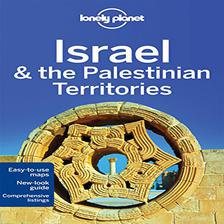

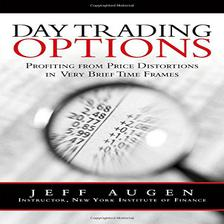

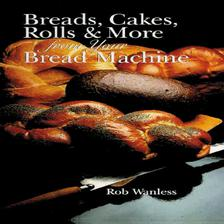

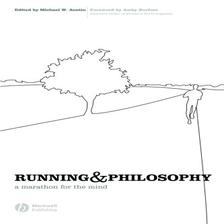

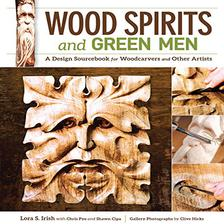

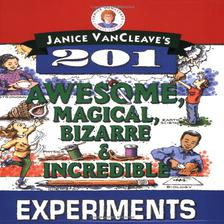

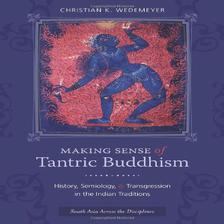

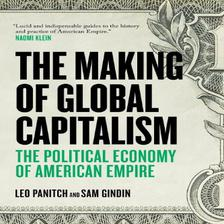

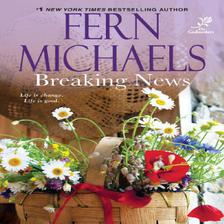

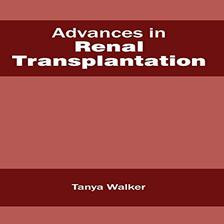

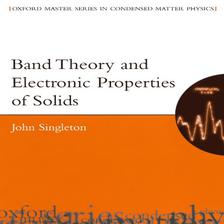

In [10]:
for image_name in X['Image_name'][10:21]:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    display(image)

In [9]:
np.array(pastel_colours).shape, np.array(average_colors).shape, np.array(most_frequent_colors).shape

((51300,), (51300, 3), (51300, 3))

### Text

In [11]:
title_words = np.array(X["Title"].str.split())

count_words = np.array([len(x) for x in title_words])
extracted_features["word_counts"] = count_words

In [12]:
count_words

array([7, 7, 7, ..., 5, 1, 8])

In [13]:
count_capital_letters = lambda s: sum(1 for c in s if c.isupper())

In [14]:
capital_counts = X["Title"].apply(count_capital_letters)

capital_ratio = np.array(capital_counts/count_words)

extracted_features["capital_ratio"] = capital_ratio

In [15]:
count_letters = lambda s: sum(1 for c in s if c.isalpha())

In [16]:
letter_counts = X["Title"].apply(count_letters)

letter_ratio = np.array(letter_counts/count_words)

extracted_features["letter_ratio"] = letter_ratio 

In [17]:
count_punctuation = lambda s: sum(1 for c in s if c in string.punctuation)

In [18]:
punct_counts = X["Title"].apply(count_punctuation)
extracted_features["punct_counts"] = punct_counts

In [38]:
extracted_features

,average_r,average_g,average_b,most_freq_r,most_freq_g,most_freq_b,mean_pastel,word_counts,capital_ratio,letter_ratio,punct_counts
0,143.9203,144.4273,126.1171,92.0,97.0,74.0,10.790976,7,0.857143,5.000000,1
1,121.6648,155.5735,171.1021,105.0,183.0,222.0,33.190390,7,1.000000,6.857143,4
2,121.4898,8.0966,7.3227,147.0,3.0,3.0,54.079550,7,1.285714,6.857143,2
3,193.1224,181.9881,103.9752,254.0,134.0,37.0,44.215443,7,0.857143,5.285714,1
4,112.0715,136.0007,169.8334,81.0,123.0,205.0,27.574149,11,0.909091,5.090909,4
...,...,...,...,...,...,...,...,...,...,...,...
51295,144.2605,98.0033,80.7424,255.0,255.0,255.0,30.494374,2,1.000000,5.500000,0
51296,91.7243,81.9982,50.0007,25.0,23.0,44.0,35.951008,9,0.777778,5.333333,1
51297,68.6990,63.3906,72.7776,19.0,22.0,27.0,10.074989,5,0.800000,4.400000,1
51298,118.8070,82.1060,69.3474,56.0,52.0,51.0,19.270203,1,1.000000,7.000000,0


In [52]:
concatenated_df = pd.concat([extracted_features, color_histograms_df], axis=1)
concatenated_df

,average_r,average_g,average_b,most_freq_r,most_freq_g,most_freq_b,mean_pastel,word_counts,capital_ratio,letter_ratio,...,color_hist_503,color_hist_504,color_hist_505,color_hist_506,color_hist_507,color_hist_508,color_hist_509,color_hist_510,color_hist_511,color_hist_512
0,143.9203,144.4273,126.1171,92.0,97.0,74.0,10.790976,7,0.857143,5.000000,...,0.009655,0.000060,0.000000,0.000000,0.000000,0.000241,0.001328,0.002172,0.010379,0.540299
1,121.6648,155.5735,171.1021,105.0,183.0,222.0,33.190390,7,1.000000,6.857143,...,0.000137,0.000000,0.036987,0.025177,0.013092,0.004807,0.000458,0.000000,0.000000,0.000000
2,121.4898,8.0966,7.3227,147.0,3.0,3.0,54.079550,7,1.285714,6.857143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,193.1224,181.9881,103.9752,254.0,134.0,37.0,44.215443,7,0.857143,5.285714,...,0.001030,0.000000,0.000000,0.000000,0.000147,0.004928,0.461424,0.693277,0.368007,0.024127
4,112.0715,136.0007,169.8334,81.0,123.0,205.0,27.574149,11,0.909091,5.090909,...,0.000000,0.000000,0.000672,0.002352,0.002436,0.001932,0.000756,0.000084,0.000588,0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51295,144.2605,98.0033,80.7424,255.0,255.0,255.0,30.494374,2,1.000000,5.500000,...,0.008257,0.003259,0.000000,0.000000,0.000000,0.000000,0.000435,0.026292,0.022706,0.435984
51296,91.7243,81.9982,50.0007,25.0,23.0,44.0,35.951008,9,0.777778,5.333333,...,0.000000,0.000000,0.066294,0.041134,0.032451,0.011466,0.003061,0.000835,0.000056,0.008572
51297,68.6990,63.3906,72.7776,19.0,22.0,27.0,10.074989,5,0.800000,4.400000,...,0.016474,0.017737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000421,0.012474,0.224105
51298,118.8070,82.1060,69.3474,56.0,52.0,51.0,19.270203,1,1.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Pipeline

## Preprocessing Pipeline

In [53]:
# CREATING CLASS AND ADDING TO PIPELINE
class EmbeddingFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=10, min_count=10, window=5):
        self.vector_size = vector_size
        self.min_count = min_count
        self.window = window
        #self.word2vec_model = None

    def fit(self, X, y=None):
        #self.X_embed = [text_to_word_sequence(str(title)) for title in X['Title']]
        #self.word2vec_model = Word2Vec(vector_size=self.vector_size, min_count=self.min_count, window=self.window)
        #self.word2vec_model.build_vocab(X_embed)
        return self
    
    def transform(self, X):
        X_embed = [text_to_word_sequence(str(title)) for title in X['Title']]
        word2vec = Word2Vec(sentences=X_embed, vector_size=self.vector_size, min_count=self.min_count, window=self.window)
        title_embeddings_avg = []
        
        for title in X_embed:
            title_embedding = []
            
            for word in title:
                if word in word2vec.wv.key_to_index:
                    word_embedding = word2vec.wv[word]
                    title_embedding.append(word_embedding)
            
            if title_embedding:
                title_embedding_avg = np.mean(title_embedding, axis=0)
                title_embeddings_avg.append(title_embedding_avg)
            else:
                title_embeddings_avg.append(np.zeros(word2vec.vector_size))
                
        title_embeddings_avg = np.array(title_embeddings_avg)
        
        return title_embeddings_avg

In [54]:
class ImageFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        average_colors = []
        most_frequent_colors = []
        pastel_colours = []
        color_histograms = []

        for image_name in X['Image_name']:
            image_path = os.path.join("../raw_data/Images/", image_name)
            image = Image.open(image_path)
            #image = image.resize((100, 100))
            image_array = np.array(image)

            # Average and most freq colours
            flattened_pixels = image_array.reshape(-1, 3)
            average_color = np.mean(flattened_pixels, axis=0)
            unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
            most_frequent_index = np.argmax(counts)
            most_frequent_color = unique[most_frequent_index]
            
            # Colour histograms
            image_hist = cv2.imread(image_path)
            histogram_image = cv2.cvtColor(image_hist, cv2.COLOR_BGR2RGB)
                
            color_histogram = cv2.calcHist([histogram_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            color_histogram = cv2.normalize(color_histogram, color_histogram).flatten()
                
            color_histograms.append(color_histogram)
            
            # Pastel colours - convert image to LAB color and calculate saturation of each pixel
            lab_image = rgb2lab(image_array)

            a_channel = lab_image[:, :, 1]
            b_channel = lab_image[:, :, 2]
            saturation = np.sqrt(a_channel**2 + b_channel**2)
            
            mean_saturation = np.mean(saturation)

            # append to lists
            average_colors.append(average_color)
            most_frequent_colors.append(most_frequent_color)
            pastel_colours.append(mean_saturation)

        average_colors = np.array(average_colors)
        most_frequent_colors = np.array(most_frequent_colors)
        pastel_colours = np.array(pastel_colours)
        color_histograms = np.array(color_histograms)
        
        return np.column_stack((average_colors, most_frequent_colors, pastel_colours, color_histograms))/255

In [55]:
class TitleFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.count_words = lambda s: len(s.split())
        self.count_capital_letters = lambda s: sum(1 for c in s if c.isupper())
        self.count_letters = lambda s: sum(1 for c in s if c.isalpha())
        self.count_punctuation = lambda s: sum(1 for c in s if c in string.punctuation)
        self.count_special_chars = lambda s: sum(1 for c in s if c == ':' or c == '-')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        extracted_features = pd.DataFrame()
        extracted_features['count_words'] = X['Title'].apply(self.count_words)
        extracted_features['capital_ratio'] = X['Title'].apply(lambda s: self.count_capital_letters(s) / self.count_words(s))
        extracted_features['letter_ratio'] = X['Title'].apply(lambda s: self.count_letters(s) / self.count_words(s))
        extracted_features['punct_counts'] = X['Title'].apply(self.count_punctuation)
        extracted_features['special_chars_ratio'] = X['Title'].apply(lambda s: self.count_special_chars(s) / self.count_words(s))
        
        return extracted_features.values

In [56]:

image_pipeline = Pipeline([
    ('image_features', ImageFeatureExtractor()),
])

title_pipeline = Pipeline([
    ('title_features', TitleFeatureExtractor()),
    ('normalize_text', MinMaxScaler())
])

embeddings = Pipeline([
    ('title_embeddings', EmbeddingFeatureExtractor())
])

preprocessing = ColumnTransformer([
    ("image", image_pipeline, ["Image_name"]),
    ("title", title_pipeline, ["Title"]),
    ("embeddings", embeddings, ["Title"])
])

In [57]:
preprocessing

ColumnTransformer(transformers=[('image',
                                 Pipeline(steps=[('image_features',
                                                  ImageFeatureExtractor())]),
                                 ['Image_name']),
                                ('title',
                                 Pipeline(steps=[('title_features',
                                                  TitleFeatureExtractor()),
                                                 ('normalize_text',
                                                  MinMaxScaler())]),
                                 ['Title']),
                                ('embeddings',
                                 Pipeline(steps=[('title_embeddings',
                                                  EmbeddingFeatureExtractor())]),
                                 ['Title'])])

In [58]:
X_preproc = None

In [59]:
X_preproc = preprocessing.fit_transform(X)

In [60]:
y_preproc = y["Genre_id"]
y_preproc_umbr = y_umbr_df['Genre_umbr_id'].astype(int)

In [61]:
print(X_preproc.shape)
print(y_preproc_umbr)

(51300, 534)
0        1
1        2
2        3
3        1
4        4
        ..
51295    5
51296    5
51297    5
51298    5
51299    5
Name: Genre_umbr_id, Length: 51300, dtype: int64


# Model

## Cross Validate

In [62]:
model = LinearSVC(max_iter=10000)

In [63]:
scores = cross_validate(model, X_preproc, y_preproc_umbr, cv=5)

In [64]:
# 8 categories
score = scores["test_score"].mean()
print(f'Mean Umbrella Score: {score*100:.2f}%')

Mean Umbrella Score: 41.07%


In [48]:
# 30 categories
#score = scores["test_score"].mean()
#print(f'Mean Score: {score*100:.2f}%')

Mean Score: 22.94%


## Train and save model

In [14]:
model = LinearSVC()

In [59]:
model.fit(X_preproc, y_preproc_umbr)

LinearSVC(max_iter=10000)

In [24]:
#dump(model, "../models/baseline_svc_v1.pkl")

['../models/baseline_svc_v1.pkl']